In [1]:
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np


### Use GPU de la mac

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device: ", device)


Using device:  mps


### Importar train y test

In [3]:
# Función para cargar datos desde archivos HDF5
def load_data(filepath):
    with h5py.File(filepath, 'r') as f:
        # Añadir dimensión de canal (1) a los espectrogramas
        spectrograms = torch.tensor(f['spectrograms'][:], dtype=torch.float32).unsqueeze(1)
        labels = torch.tensor(f['labels'][:], dtype=torch.long)
    return spectrograms, labels

# Cargar datos de entrenamiento y prueba
train_spectrograms, train_labels = load_data('/Users/elcachorrohumano/workspace/MusicNN/data/train/spec_train.h5')
test_spectrograms, test_labels = load_data('/Users/elcachorrohumano/workspace/MusicNN/data/test/spec_test.h5')


# Obtener las dimensiones del espectrograma
_, channels, height, width = train_spectrograms.shape
print(f"Forma de los datos: {train_spectrograms.shape}")


Forma de los datos: torch.Size([2906, 1, 128, 641])


### Crear DataLoader para entrenamiento y prueba

In [4]:
batch_size = 64
train_loader = DataLoader(TensorDataset(train_spectrograms, train_labels), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(test_spectrograms, test_labels), batch_size=batch_size)


### CNN

In [5]:
class ImprovedCNN(nn.Module):
    def __init__(self, input_height, input_width):
        super(ImprovedCNN, self).__init__()
        
        # Primera capa convolucional
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25)
        )
        
        # Segunda capa convolucional
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25)
        )
        
        # Tercera capa convolucional
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25)
        )
        
        # Calcular el tamaño de la salida después de las capas convolucionales
        self.height_after_conv = input_height // 8  # Debido a 3 capas de pooling
        self.width_after_conv = input_width // 8
        
        # Capas fully connected
        self.fc = nn.Sequential(
            nn.Linear(128 * self.height_after_conv * self.width_after_conv, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 128 * self.height_after_conv * self.width_after_conv)
        x = self.fc(x)
        return x

### Inicializar la red, la pérdida y el optimizador


In [6]:
num_classes = len(set(train_labels.numpy()))
model = ImprovedCNN(height, width).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)



/Users/elcachorrohumano/opt/anaconda3/envs/music_env/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Función para calcular la precisión por clase

In [7]:
def calculate_class_accuracy(model, data_loader, num_classes):
    model.eval()
    correct_pred = {classid: 0 for classid in range(num_classes)}
    total_pred = {classid: 0 for classid in range(num_classes)}
    
    with torch.no_grad():
        for spectrograms, labels in data_loader:
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            outputs = model(spectrograms)
            _, predictions = torch.max(outputs, 1)
            
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[label.item()] += 1
                total_pred[label.item()] += 1
    
    class_accuracy = {}
    for classid in range(num_classes):
        if total_pred[classid] > 0:
            class_accuracy[classid] = correct_pred[classid] / total_pred[classid]
        else:
            class_accuracy[classid] = 0
    
    return class_accuracy

### Entrenamiento

In [8]:
epochs = 30
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
best_train_accuracy = 0.0

for epoch in range(epochs):
    # Entrenamiento
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for spectrograms, labels in train_loader:
        spectrograms, labels = spectrograms.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(spectrograms)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        running_loss += loss.item()
        
        # Calcular precisión de entrenamiento
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    # Evaluación
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for spectrograms, labels in test_loader:
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            outputs = model(spectrograms)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    # Calcular métricas
    avg_train_loss = running_loss / len(train_loader)
    avg_test_loss = test_loss / len(test_loader)
    train_accuracy = train_correct / train_total
    test_accuracy = test_correct / test_total
    
    # Actualizar el learning rate
    scheduler.step(avg_test_loss)
    
    # Guardar métricas
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
    # Calcular precisión por clase cada 5 épocas
    if (epoch + 1) % 5 == 0:
        class_accuracy = calculate_class_accuracy(model, test_loader, num_classes)
        print("\nPrecisión por clase:")
        for classid, acc in class_accuracy.items():
            print(f"Clase {classid}: {acc:.4f}")
    
    # Imprimir progreso
    print(f"\nEpoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    
    # Guardar el mejor modelo basado en la precisión de entrenamiento
    if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Nuevo mejor modelo guardado con precisión de entrenamiento: {train_accuracy:.4f}")
    
    print("-" * 50)


Epoch 1/30
Train Loss: 8.5826, Train Accuracy: 0.5086
Test Loss: 0.6685, Test Accuracy: 0.6172
Nuevo mejor modelo guardado con precisión de entrenamiento: 0.5086
--------------------------------------------------

Epoch 2/30
Train Loss: 0.7791, Train Accuracy: 0.5444
Test Loss: 0.6377, Test Accuracy: 0.6406
Nuevo mejor modelo guardado con precisión de entrenamiento: 0.5444
--------------------------------------------------

Epoch 3/30
Train Loss: 0.6720, Train Accuracy: 0.6191
Test Loss: 0.5470, Test Accuracy: 0.7871
Nuevo mejor modelo guardado con precisión de entrenamiento: 0.6191
--------------------------------------------------

Epoch 4/30
Train Loss: 0.6375, Train Accuracy: 0.6583
Test Loss: 0.5257, Test Accuracy: 0.7754
Nuevo mejor modelo guardado con precisión de entrenamiento: 0.6583
--------------------------------------------------

Precisión por clase:
Clase 0: 0.8228
Clase 1: 0.7326

Epoch 5/30
Train Loss: 0.5911, Train Accuracy: 0.7085
Test Loss: 0.4528, Test Accuracy: 0

### Visualización del entrenamiento

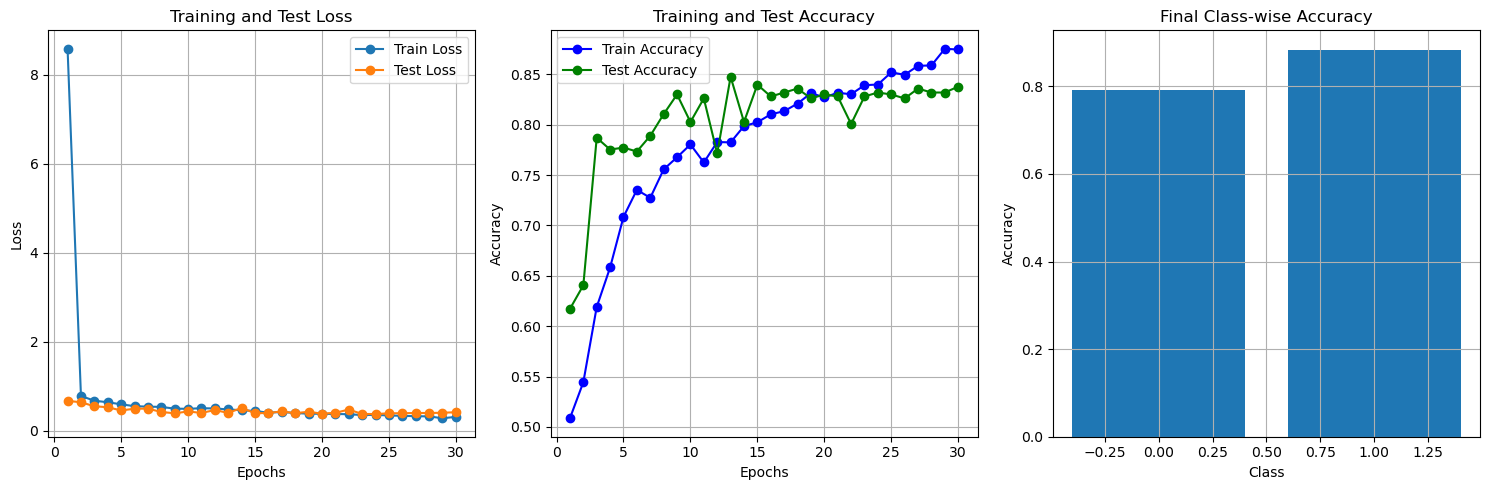

In [9]:
plt.figure(figsize=(15, 5))

# Gráfico de pérdida
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, epochs + 1), test_losses, label="Test Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()
plt.grid(True)

# Gráfico de accuracy
plt.subplot(1, 3, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label="Train Accuracy", marker='o', color='blue')
plt.plot(range(1, epochs + 1), test_accuracies, label="Test Accuracy", marker='o', color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy")
plt.legend()
plt.grid(True)

# Gráfico de precisión por clase final
plt.subplot(1, 3, 3)
final_class_accuracy = calculate_class_accuracy(model, test_loader, num_classes)
plt.bar(range(num_classes), [final_class_accuracy[i] for i in range(num_classes)])
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.title("Final Class-wise Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()